# Test model for some dastardly errors

A simplified version of the subduction wedge. 

Using Q1 elements:

* This model will run at resolutions 32, 64, 128, if the mg levels are the default ones
* It fails at 48, 96 no matter what the mg levels are set to

Using Q2 elements

* The models fails under all Resolution / mg level combinations tested

In [30]:
import numpy as np
import underworld as uw
import math
from underworld import function as fn
import glucifer
from mpi4py import MPI

In [34]:
res = 32
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"), 
                                 elementRes  = (res, res), 
                                 minCoord    = (0., 0.), 
                                 maxCoord    = (1., 1.))

velocityField    = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=2 )
pressureField    = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )

stressField   = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=3 )


In [35]:
velocityField.data[:] = [0.,0.]
pressureField.data[:] = 0.
stressField.data[...] = (0.0,0.0,0.0)

In [36]:
nodes = np.where(mesh.data[:,1] < 1e-3 + (1. - mesh.data[:,0]))[0]


drivenVelNodes = mesh.specialSets["Empty"]
drivenVelNodes.add(nodes)

In [37]:
velocityField.data[nodes]= np.sqrt(0.5), -1.*np.sqrt(0.5)


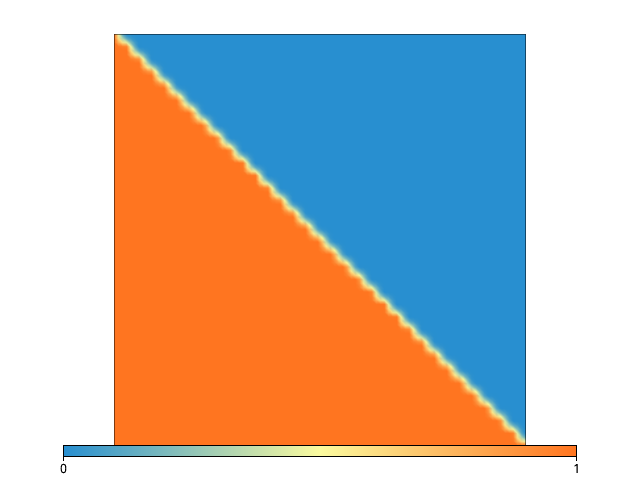

In [38]:
fig= glucifer.Figure(quality=3)
fig.append( glucifer.objects.Surface(mesh, fn.math.dot(velocityField, velocityField)))
fig.show()

In [39]:
iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]
tWalls = mesh.specialSets["MaxJ_VertexSet"]
bWalls =mesh.specialSets["MinJ_VertexSet"]
lWalls = mesh.specialSets["MinI_VertexSet"]
rWalls = mesh.specialSets["MaxI_VertexSet"]
      

Populating the interactive namespace from numpy and matplotlib


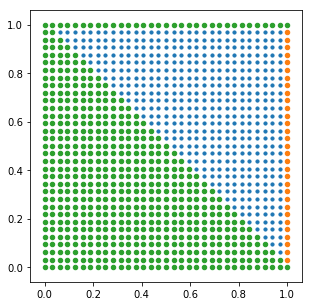

In [40]:
%pylab inline
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(mesh.data[:,0], mesh.data[:,1],s = 10)

neumannNodes = rWalls - tWalls - bWalls 
dirichNodes = drivenVelNodes + tWalls

ax.scatter(mesh.data[neumannNodes.data][:,0], mesh.data[neumannNodes.data][:,1],s = 20)
ax.scatter(mesh.data[dirichNodes.data][:,0], mesh.data[dirichNodes.data][:,1],s = 20)

#ax.scatter(fault.swarm.particleCoordinates.data[:,0], fault.swarm.particleCoordinates.data[:,1],s = 30)


ax.set_aspect('equal')
#ax.set_ylim(0.35, 0.65)
#ax.set_xlim(-0.15, 0.15)

In [41]:
#Stokes BCs


#Neumann on RHS nodes minus the bottom and top node 
velNbc = uw.conditions.NeumannCondition( flux=stressField, 
                                      variable=velocityField,
                                      nodeIndexSet=(rWalls - tWalls - bWalls ) )


#Dirichlet conditions on nodes including and beneath the main diagonal, as well as topWalls
velDbc = uw.conditions.DirichletCondition( variable      = velocityField, 
                                               indexSetsPerDof = ( tWalls + drivenVelNodes,  tWalls + drivenVelNodes) )

In [42]:
stokesPIC = uw.systems.Stokes( velocityField  = velocityField, 
                                   pressureField  = pressureField,
                                   conditions     = [velDbc,velNbc],
                                   fn_viscosity   = 1., 
                                   fn_bodyforce   = (0., 0.) )

In [43]:
solver = uw.systems.Solver(stokesPIC)


In [44]:
solver.options.main.Q22_pc_type='gkgdiag'
#solver.options.scr.ksp_rtol=5e-5
solver.set_inner_method('mg')
#solver.options.mg.levels = 5

In [45]:
#solver.options.mg.levels = 4

In [46]:
#solver.options.mg.levels, solver.options.scr.ksp_rtol, solver.get_stats()

In [47]:
solver.solve()


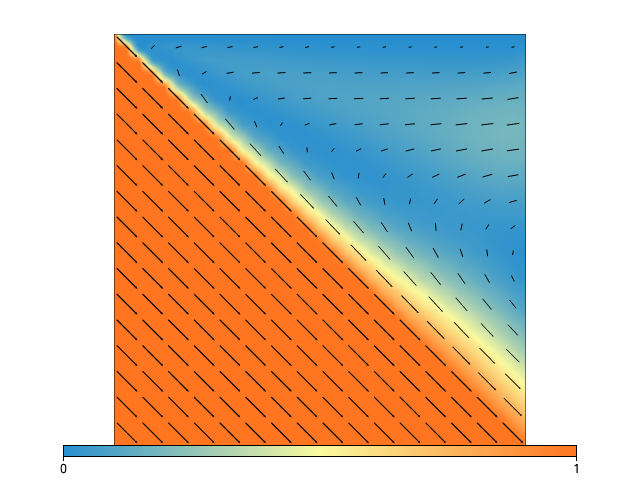

In [48]:
fig= glucifer.Figure(quality=3)

fig.append( glucifer.objects.Surface(mesh, fn.math.dot(velocityField, velocityField)))
fig.append( glucifer.objects.VectorArrows(mesh, velocityField*0.07))


fig.show()